<a href="https://colab.research.google.com/github/playanaC/EleganSeg/blob/main/1_Demo_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar 31 11:55:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;)
!python -m pip install -U roifile
!pip install XlsxWriter
!pip install joblib
!pip install file-split-merge

import warnings
warnings.filterwarnings('ignore')

!git clone https://github.com/playanaC/EleganSeg.git
%cd /content/EleganSeg/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for file-split-merge: filename=file_split_merge-1.0.0-py3-none-any.whl size=6734 sha256=fd0fcc05cb4791129b495093ed5e4e8f2861f7a950ce5f8c13bec6a6274d95f3
  Stored in directory: /root/.cache/pip/wheels/a9/70/d8/72822d5d0889baca2ae35071797c57158606dc4cd8d04c7a98
Successfully built file-split-merge
Cloning into 'EleganSeg'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote:

In [4]:
#@title **Please, provide the necessary input files below:** 
import os
base = '/content/EleganSeg/' #@param {type:"string"}

checkpoint_SEG = '/content/EleganSeg/Data/network/SEG/' #@param {type:"string"}
checkpoint_SKL = '/content/EleganSeg/Data/network/SKL/' #@param {type:"string"}

test_images = '/content/EleganSeg/Data/demo_images/images/' #@param {type:"string"}
print('Input images:', test_images)

test_mask = '/content/EleganSeg/Data/demo_images/' #@param {type:"string"}
print('Masks tagged:', test_mask)

save_dir = '/content/drive/MyDrive/demo_images/' #@param {type:"string"}
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print('Output images:', save_dir)

Input images: /content/EleganSeg/Data/demo_images/images/
Masks tagged: /content/EleganSeg/Data/demo_images/
Output images: /content/drive/MyDrive/demo_images/


In [5]:
#@title **Unzip networks, images**
import zipfile

# unzip networks
network_SEG = checkpoint_SEG + 'model.pth'
!file_split_merge -m -i $network_SEG

network_SKL = checkpoint_SKL + 'model.pth'
!file_split_merge -m -i $network_SKL

# unzip images
mask_zip = test_mask + 'mask.zip'
path_save_maks = test_mask + '/masks/'

with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
    zip_ref.extractall(path_save_maks)
    
test_mask = path_save_maks


------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SEG/model.pth
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 0 seconds

------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SKL/model.pth
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 0 seconds


cuda
Processing: SEGMENTATION + SKELETON


100%|██████████| 4/4 [00:26<00:00,  5.32s/img]

 
Image shown: Image89.tif


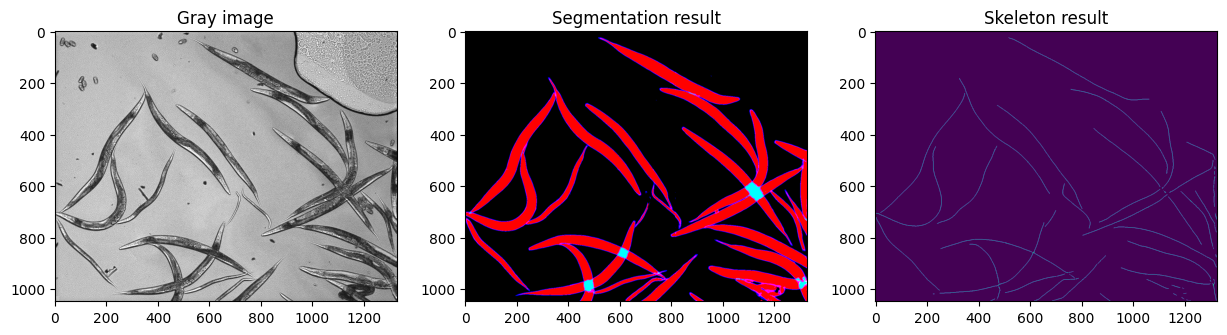

100%|██████████| 4/4 [00:27<00:00,  6.82s/img]


In [6]:
#@title **Begin Evaluating**
from tqdm import tqdm
import cv2
import torch
from utils import *
import matplotlib.pyplot as plt

end_gray_image = '.tif' #@param {type:"string"}
batch_crop_img = 9 #@param {type: "integer"}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

path_SKELETON = save_dir + '0_SKELETON/'
path_SEGMENTATION = save_dir + '0_SEGMENTATION/'

if not os.path.exists(path_SKELETON):
    os.makedirs(path_SKELETON)

if not os.path.exists(path_SEGMENTATION):
    os.makedirs(path_SEGMENTATION)

list_images = sorted(list_files(test_images, end_gray_image))
print('Processing: SEGMENTATION + SKELETON')

with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        # name_image = list_images[q]
        name_image_ = name_image.split('.')[0]
        name_image_save = name_image_ + '.bmp'

        if not os.path.exists(path_SEGMENTATION + name_image_save):
            path_image_gray = test_images + name_image

            # image_gray = tifffile.imread(path_image_gray).astype(np.float32)
            image_gray = imread_image(path_image_gray)  # read gray image
            if len(image_gray.shape) > 2:
                image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
            h, w = image_gray.shape

            # Obtain segmentation from Network1
            dir_checkpoint_seg = checkpoint_SEG + 'model.pth'
            image_seg = get_image_network(device=device, dir_checkpoint=dir_checkpoint_seg, n_classes=4,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)

            # Obtain Skeleton from Network2
            dir_checkpoint_skl = checkpoint_SKL + 'model.pth'
            image_skl = get_image_network(device=device, dir_checkpoint=dir_checkpoint_skl, n_classes=1,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)
            cv2.imwrite(path_SEGMENTATION + name_image_save, image_seg)
            cv2.imwrite(path_SKELETON + name_image_save, image_skl)
        pbar.update(1)

    print(' ')
    print('Image shown:', name_image)
    name_image_00 = name_image
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(131)
    ax1.title.set_text('Gray image')
    ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

    ax2 = fig.add_subplot(132)
    ax2.title.set_text('Segmentation result')
    ax2.imshow(image_seg)

    ax3 = fig.add_subplot(133)
    ax3.title.set_text('Skeleton result')
    ax3.imshow(image_skl)
    plt.show()

Folder good masks: /content/drive/MyDrive/demo_images/1_good_mask/
Folder bad masks: /content/drive/MyDrive/demo_images/1_bad_mask/
Folder overlap masks: /content/drive/MyDrive/demo_images/1_overlap/
Folder save_results: /content/drive/MyDrive/demo_images/0_RGB_results/


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.4min finished


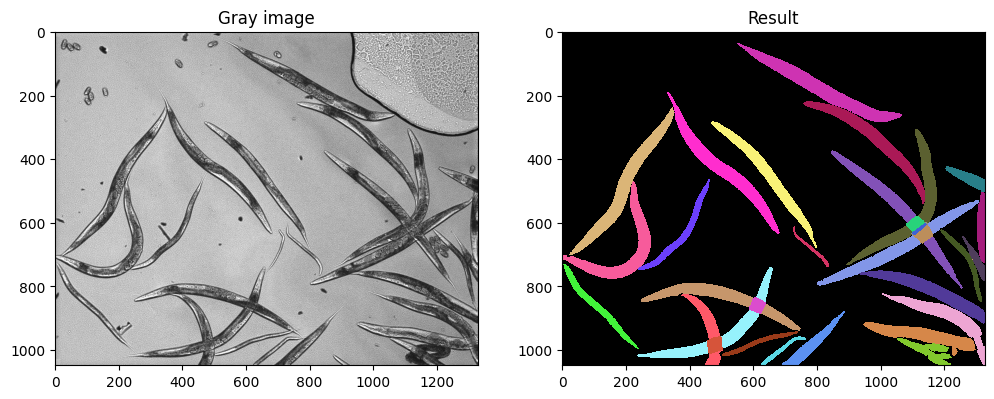

In [7]:
#@title **Begin post-processing**
#@markdown Check if you want to split into subprocesses.
Parallel_process = True #@param {type:"boolean"}

#@markdown Enter the number of subprocesses to split.
N_process = 4 #@param {type:"number"}

area_percentage = 60
area_min = 600
kernel_size = 3
angle_value = 20

#@markdown Enter the paths  where the images will be saved.
path_save = save_dir + '0_RGB_results/' #@param {type:"string"}
path_good_mask = save_dir + '1_good_mask/' #@param {type:"string"}
path_bad_mask = save_dir + '1_bad_mask/' #@param {type:"string"}
path_overlap = save_dir + '1_overlap/' #@param {type:"string"}

print('Folder good masks:', path_good_mask)
print('Folder bad masks:', path_bad_mask)
print('Folder overlap masks:', path_overlap)
print('Folder save_results:', path_save)

import numpy as np
from utils import *
from skimage import measure
from joblib import Parallel, delayed

args = {'Parallel_process': Parallel_process,
        'path_images': test_images,
        'path_SEGMENTATION': path_SEGMENTATION,
        'path_SKELETON': path_SKELETON,
        'path_good_mask': path_good_mask,
        'path_bad_mask': path_bad_mask,
        'path_overlap': path_overlap,
        'path_save': path_save,
        'area_percentage': area_percentage,
        'area_min': area_min,
        'kernel_size': kernel_size,
        'angle_value': angle_value
        }

def post_processing(args, name_image):
    name_image_ = name_image.split('.')[0]
    name_image_save = name_image_ + '.bmp'
    image_seg = cv2.imread(args['path_SEGMENTATION'] + name_image_save)

    if not os.path.exists(args['path_save'] + name_image_ + '.jpg'):
        image_skl = cv2.imread(args['path_SKELETON'] + name_image_save)
        image_skl = (cv2.cvtColor(image_skl, cv2.COLOR_BGR2GRAY) > 0) * 255

        area_min = args['area_min']
        angle_value = args['angle_value']
        kernel_size = args['kernel_size']
        area_percentage = args['area_percentage']

        path_images = args['path_images']
        path_good_mask = args['path_good_mask']
        path_bad_mask = args['path_bad_mask']
        path_overlap = args['path_overlap']
        path_save = args['path_save']
        path_rois = args['path_rois']

        if not os.path.exists(path_good_mask):
            os.makedirs(path_good_mask)

        if not os.path.exists(path_bad_mask):
            os.makedirs(path_bad_mask)

        if not os.path.exists(path_overlap):
            os.makedirs(path_overlap)

        if not os.path.exists(path_save):
            os.makedirs(path_save)

        # ***************** Improve edge detection ****************************************************
        edge_final = check_edge_worms(image_seg, kernel_size)

        # ***************** none overlappings and overlappings *******************************************
        none_overlappings, overlapping = obtain_overlappings(image_seg, edge_final, kernel_size + 2)
        labels_overlapping = measure.label(overlapping, background=0)
        labels_none_overlapping = measure.label(none_overlappings, background=0)

        # ************************** None-overlappings ***************************************************
        true_overlaps = check_overlapping(labels_overlapping, labels_none_overlapping)
        mask_worms = get_none_overlapping(labels_none_overlapping, true_overlaps, area_min, kernel_size)  # none-overl
        mask_worms_Dims = worms2NDims(mask_worms, kernel_size + 2)  # each dimension is a worm
        results_masks_NO = check_noneOverlapping(mask_worms_Dims, area_percentage)  # Check good/bad masks

        # ************************** overlappings ********************************************************
        mask_overlaps_Dims = overlapping_worms(true_overlaps, mask_worms, labels_overlapping,
                                               labels_none_overlapping, image_skl, area_min,
                                               kernel_size+2, angle_value)

        # ***************************** Save imgs results *****************************************************
        name_image_final = path_save + name_image_ + '.jpg'
        path_image_gray = path_images + name_image
        image_gray = imread_image(path_image_gray)  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        save_results_mask(name_image_final, image_gray, results_masks_NO, mask_overlaps_Dims, 1)  # RGB

        save_mask_tif(path_good_mask + name_image, results_masks_NO['worms_good'])
        save_mask_tif(path_bad_mask + name_image, results_masks_NO['worms_bads'])
        save_mask_tif(path_overlap + name_image, mask_overlaps_Dims)

        # ***************************** Save rois *****************************************************                # save_mask_rois(path_good_mask, results_masks_NO['worms_good'])
        save_mask_rois(path_good_mask + name_image_ + '.zip', results_masks_NO['worms_good'])
        save_mask_rois(path_bad_mask + name_image_ + '.zip', results_masks_NO['worms_bads'])
        save_mask_rois(path_overlap + name_image_ + '.zip', mask_overlaps_Dims)

if Parallel_process:
    Parallel(n_jobs=N_process, verbose=1, backend='multiprocessing')(
        delayed(post_processing)(args, name_image) for name_image in list_images)
else:
    with tqdm(total=len(list_images), unit='img') as pbar:
        for name_image in list_images:
            post_processing(args, name_image)
            pbar.update(1)

## Show results
from utils import imread_image, read_tiff_mask, Ndims2image
name_image_showed = name_image_00
path_image_gray = test_images + name_image_showed
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)

image_good_mask = path_good_mask + name_image_showed
image_bad_mask = path_bad_mask + name_image_showed
image_overlap_mask = path_overlap + name_image_showed

image_good_mask = read_tiff_mask(image_good_mask)
image_bad_mask = read_tiff_mask(image_bad_mask)
image_overlap_mask = read_tiff_mask(image_overlap_mask)

masK_predict_all = np.concatenate((image_good_mask, image_bad_mask), axis=0)
masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
worms_all, new_map = Ndims2image(masK_predict_all, 1)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Gray image')
ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

ax2 = fig.add_subplot(122)
ax2.title.set_text('Result')
ax2.imshow(worms_all, cmap=new_map, interpolation='None')
fig = plt.gcf()
fig.set_size_inches(12, 12)

# ## Show results masks
# name_image_ = name_image_showed.split('.')[0]
# name_image_result = path_save + name_image_ + '.jpg'
# image_result = cv2.imread(name_image_result)

# plt.figure(figsize=(15, 15))
# plt.imshow(image_result)
# fig = plt.gcf()
# fig.set_size_inches(12, 12)
# plt.show()

 
IoU_image: 0.9426739549535254
IoU per worm: 0.9017477758754973
Img_percentage: 100.0 %


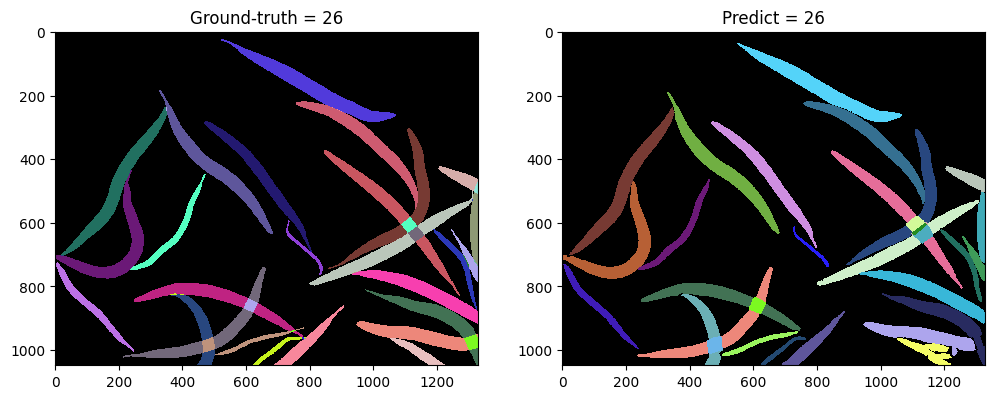

In [9]:
#@title **Begin IoU processing**
#@markdown Enter the percentage of overlap between ground-truth and prediction.
percentage_overlap = 50 #@param {type:"number"}

from tqdm import tqdm
import pandas as pd
import tifffile
import numpy as np
from utils import NDims2worms, iou_img, IoU_per_worm, get_centroid

## Show results
from utils import imread_image, read_tiff_mask, Ndims2image
name_image_showed = name_image_00
path_image_gray = test_images + name_image_showed
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)

image_ground_truth_masK = test_mask + name_image_showed
image_good_mask = path_good_mask + name_image_showed
image_bad_mask = path_bad_mask + name_image_showed
image_overlap_mask = path_overlap + name_image_showed

image_ground_truth_masK = read_tiff_mask(image_ground_truth_masK)
image_good_mask = read_tiff_mask(image_good_mask)
image_bad_mask = read_tiff_mask(image_bad_mask)
image_overlap_mask = read_tiff_mask(image_overlap_mask)

masK_predict_all = np.concatenate((image_good_mask, image_bad_mask), axis=0)
masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
worms_all, new_map = Ndims2image(masK_predict_all, 1)
centroid_predict, label_predict = get_centroid(masK_predict_all, 1)

worms_ground_truth, _ = Ndims2image(image_ground_truth_masK, 1)
centroid_ground_truth, label_ground_truth = get_centroid(image_ground_truth_masK, 1)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Ground-truth = ' + str(len(centroid_ground_truth)))
ax1.imshow(worms_ground_truth, cmap=new_map, interpolation='None')

ax2 = fig.add_subplot(122)
ax2.title.set_text('Predict = ' + str(len(centroid_predict)))
ax2.imshow(worms_all, cmap=new_map, interpolation='None')
# plt.show()
fig = plt.gcf()
fig.set_size_inches(12, 12)

masK_ground_truth = (worms_ground_truth > 0) * 255
masK_predict = (worms_all > 0) * 255
IoU = iou_img(masK_ground_truth, masK_predict)
IoU_x_worm, percentage = IoU_per_worm(image_ground_truth_masK, masK_predict_all, percentage_overlap/100)

print(' ')
print('IoU_image:', IoU)
print('IoU per worm:', IoU_x_worm)
print('Img_percentage:', percentage * 100, '%')